In [1]:
import os
os.environ["WANDB_DISABLED"] = "true"

In [2]:
# Step 1: Install Required Libraries
!pip install transformers datasets scikit-learn -q

# Step 2: Import Libraries
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, roc_curve
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from transformers import DataCollatorWithPadding
from datasets import Dataset
import numpy as np

In [3]:
# Step 3: Load Dataset
true_df = pd.read_csv("/content/drive/MyDrive/True.csv")
fake_df = pd.read_csv("/content/drive/MyDrive/Fake.csv")

true_df['label'] = 1
fake_df['label'] = 0

df = pd.concat([true_df, fake_df]).sample(frac=1).reset_index(drop=True)
df['text'] = df['title'] + " " + df['text']

In [16]:
# Assuming you're using pandas DataFrames
true_df20 = true_df.sample(frac=0.2, random_state=42).copy()
fake_df20 = fake_df.sample(frac=0.2, random_state=42).copy()

true_df20['label'] = 1
fake_df20['label'] = 0

df = pd.concat([true_df20, fake_df20]).sample(frac=1, random_state=42).reset_index(drop=True)
df['text'] = df['title'] + " " + df['text']

In [17]:
# Step 4: Split Dataset
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df['text'].tolist(), df['label'].tolist(), test_size=0.2, random_state=42
)

In [12]:
# Step 5: Tokenization
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [18]:
# Step 5: Tokenization
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=512)
test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=512)

In [8]:
import pickle

with open("/content/drive/MyDrive/train_encodings.pkl", "wb") as f:
    pickle.dump(train_encodings, f)

with open("/content/drive/MyDrive/test_encodings.pkl", "wb") as f:
    pickle.dump(test_encodings, f)


In [7]:
import numpy as np

# Save train encodings
np.savez("/content/drive/MyDrive/train_encodings.npz",
         input_ids=train_encodings['input_ids'],
         attention_mask=train_encodings['attention_mask'])

# Save test encodings
np.savez("/content/drive/MyDrive/test_encodings.npz",
         input_ids=test_encodings['input_ids'],
         attention_mask=test_encodings['attention_mask'])

In [19]:
# Step 6: Convert to HuggingFace Dataset
train_dataset = Dataset.from_dict({
    'input_ids': train_encodings['input_ids'],
    'attention_mask': train_encodings['attention_mask'],
    'label': train_labels
})

test_dataset = Dataset.from_dict({
    'input_ids': test_encodings['input_ids'],
    'attention_mask': test_encodings['attention_mask'],
    'label': test_labels
})

In [20]:
# Step 7: Load BERT Model
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [21]:
# Step 8: Define Evaluation Metrics
def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    probs = torch.nn.functional.softmax(torch.tensor(pred.predictions), dim=1)[:, 1].numpy()

    acc = accuracy_score(labels, preds)
    auc = roc_auc_score(labels, probs)
    prec = precision_score(labels, preds)

    fpr, tpr, thresholds = roc_curve(labels, probs)
    eer_threshold = thresholds[np.nanargmin(np.absolute((1 - tpr) - fpr))]
    eer = fpr[np.nanargmin(np.absolute((1 - tpr) - fpr))]

    return {
        'accuracy': acc,
        'auc': auc,
        'precision': prec,
        'eer': eer
    }

In [11]:
# Step 9: Training Arguments
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model='accuracy',
)

TypeError: TrainingArguments.__init__() got an unexpected keyword argument 'evaluation_strategy'

In [22]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./results",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10
)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [23]:
# Step 10: Trainer API
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    data_collator=DataCollatorWithPadding(tokenizer),
    compute_metrics=compute_metrics
)

<ipython-input-23-c5a878e58026>:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [18]:
import os
os.environ["WANDB_DISABLED"] = "true"

In [24]:
# Step 11: Train the Model
trainer.train()

Step,Training Loss
10,0.553000
20,0.140400
30,0.054800
40,0.037300
50,0.024800
60,0.001200
70,0.000600
80,0.036700
90,0.082100
100,0.000500


TrainOutput(global_step=1347, training_loss=0.01043717107051861, metrics={'train_runtime': 2052.2031, 'train_samples_per_second': 10.5, 'train_steps_per_second': 0.656, 'total_flos': 5669780131952640.0, 'train_loss': 0.01043717107051861, 'epoch': 3.0})

In [27]:
# Save the fine-tuned model
trainer.save_model("/content/drive/MyDrive/saved_model/")

# Also save the tokenizer (important!)
tokenizer.save_pretrained("/content/drive/MyDrive/saved_model/")

('/content/drive/MyDrive/saved_model/tokenizer_config.json',
 '/content/drive/MyDrive/saved_model/special_tokens_map.json',
 '/content/drive/MyDrive/saved_model/vocab.txt',
 '/content/drive/MyDrive/saved_model/added_tokens.json')

In [28]:
# Step 12: Evaluate the Model
results = trainer.evaluate()
print("Final Evaluation Metrics:")
for k, v in results.items():
    print(f"{k}: {v:.4f}")

Final Evaluation Metrics:
eval_loss: 0.0001
eval_accuracy: 1.0000
eval_auc: 1.0000
eval_precision: 1.0000
eval_eer: 0.0000
eval_runtime: 53.7786
eval_samples_per_second: 33.3960
eval_steps_per_second: 2.1010
epoch: 3.0000


In [29]:
# Run predictions on validation or test set
predictions = trainer.predict(test_dataset)

# Extract logits and true labels
y_logits = predictions.predictions
y_true = predictions.label_ids

# Convert logits to probabilities using softmax (for multi-class) or sigmoid (for binary)
from scipy.special import softmax

y_prob = softmax(y_logits, axis=1)[:, 1]  # Probabilities for class 1 (real news)
y_pred = (y_prob >= 0.5).astype(int)      # Threshold at 0.5 for binary prediction

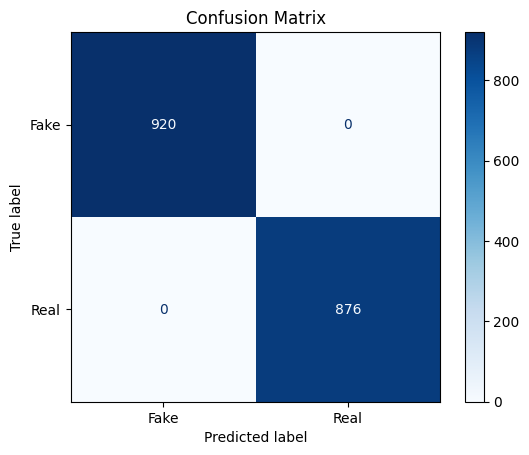

In [30]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Fake", "Real"])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.grid(False)
plt.show()

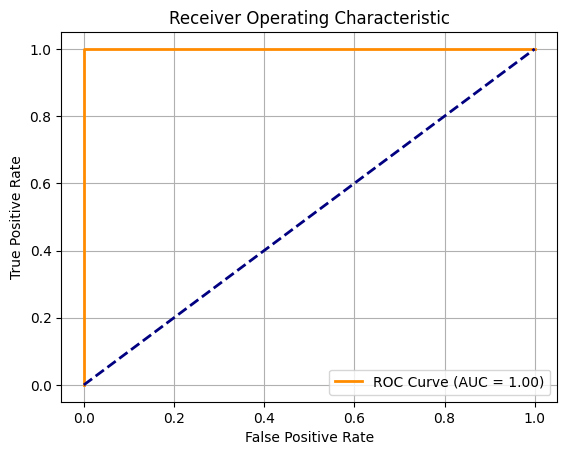

In [31]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_true, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.grid()
plt.show()

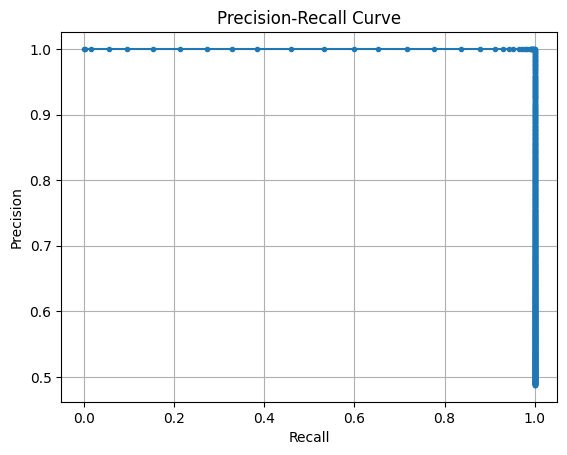

In [32]:
from sklearn.metrics import precision_recall_curve

precision, recall, _ = precision_recall_curve(y_true, y_prob)

plt.figure()
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid()
plt.show()

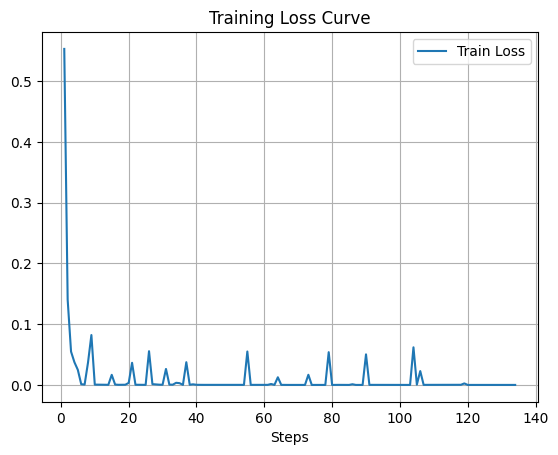

In [34]:
# Plot loss curve from Trainer logs
logs = trainer.state.log_history
train_loss = [log["loss"] for log in logs if "loss" in log]
eval_acc = [log["eval_accuracy"] for log in logs if "eval_accuracy" in log]
steps = list(range(1, len(train_loss)+1))

plt.plot(steps, train_loss, label="Train Loss")
plt.xlabel("Steps")
plt.title("Training Loss Curve")
plt.legend()
plt.grid()
plt.show()

In [36]:
import shutil

# Create target directories in Drive
!mkdir -p /content/drive/MyDrive/fake-news/results
!mkdir -p /content/drive/MyDrive/fake-news/logs

# Move the results and logs folders
shutil.move('./results', '/content/drive/MyDrive/fake-news/results')
shutil.move('./logs', '/content/drive/MyDrive/fake-news/logs')

'/content/drive/MyDrive/fake-news/logs/logs'

In [37]:
import json

# Save as JSON
with open('/content/drive/MyDrive/fake-news/training_args.json', 'w') as f:
    json.dump(training_args.to_dict(), f, indent=4)

In [6]:
import pickle

with open("/content/drive/MyDrive/train_encodings.pkl", "rb") as f:
    train_encodings = pickle.load(f)

with open("/content/drive/MyDrive/test_encodings.pkl", "rb") as f:
    test_encodings = pickle.load(f)

In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification

# Load model and tokenizer from the saved directory
model = BertForSequenceClassification.from_pretrained("/content/drive/MyDrive/saved_model/")
tokenizer = BertTokenizer.from_pretrained("/content/drive/MyDrive/saved_model/")

In [6]:
# Load train encodings
train_data = np.load("train_encodings.npz", allow_pickle=True)
train_encodings = {
    'input_ids': train_data['input_ids'].tolist(),
    'attention_mask': train_data['attention_mask'].tolist()
}

# Load test encodings
test_data = np.load("test_encodings.npz", allow_pickle=True)
test_encodings = {
    'input_ids': test_data['input_ids'].tolist(),
    'attention_mask': test_data['attention_mask'].tolist()
}


FileNotFoundError: [Errno 2] No such file or directory: 'train_encodings.npz'